<a href="https://colab.research.google.com/github/jtapiav/github-slideshow/blob/master/GA_StandardTopology.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Algortimos Géneticos

## Dependencias

In [1]:
# Dependencias
!pip install graph-lib

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 814.2/814.2 kB 12.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for graph-lib: filename=graph_lib-0.4.8-py3-none-any.whl size=962214 sha256=cacc8424ca963bb29aa3da6e37d0778bd579262c6032c91c69b1043c36239a2a
  Stored in directory: /root/.cache/pip/wheels/9e/4b/1b/8e0708331288393e6bbe3c7824a6fe31b5b91f4f3a727540c4
Successfully built graph-lib


## Bibliotecas

In [2]:
# Bibliotecas
import numpy as np
import math
import matplotlib.pyplot as plt

### Clase GeneticAlgorithm

In [3]:
class GeneticAlgorithm():
  def __init__( self, populationSize, chromosomeSize, 
               mutationType, crossoverType, selectionType, 
               calculateFitness,
               plotResult,
               epsilon, numberMaximumIterations,   
               initial_individual = None,             
               randomState = None, geneLimits = None ):
  
    np.random.seed( randomState )
    self.populationSize = populationSize
    self.chromosomeSize = chromosomeSize

    self.mutationType   = mutationType
    self.crossoverType  = crossoverType
    self.selectionType  = selectionType

    self.numberOfIteration = 0
    self.geneLimits        = geneLimits
    self.randomState       = randomState

    self.epsilon                 = epsilon
    self.numberMaximumIterations = numberMaximumIterations

    self.initial_individual      = initial_individual
    self.population              = [] #
    self.populationValue         = None #
    self.fitnessScores           = None #
    self.bestCandidateGeneration = None #
    self.fitnessScoresAverage    = [] #

    #self.calculateFitness
    self.plotResult       = plotResult

    self.bestCandidateOfGeneration = []
    self.bestFitnessOfGeneration   = []    
    self.valueBestOfGeneration     = None

    
  def generateRandomPopulation( self ):
    population = []
    if self.initial_individual is not None:
      population.append( self.initial_individual )
    
    number_remaining_individuals = self.populationSize - len(population)
    for _ in range( number_remaining_individuals ):
      individual = np.random.randint( 2, size=self.chromosomeSize )
      population.append( individual )
    return population
    #population = []
    #for index in range( self.populationSize ):
    #  individual = np.random.randint( 2, size=self.chromosomeSize )
    #  population.append( individual )
    #return population

  def bestCandidateSelection( self ):
    bestOfGenerationIndex = np.argmax( self.fitnessScores )
    return bestOfGenerationIndex

  def rankingSelection( self, numberOfElements ):
    sortedIndexes = np.argsort( -self.fitnessScores )
    selectedIndexes = sortedIndexes[:numberOfElements]
    return selectedIndexes
    
  def tournamentSelection( self, numberOfElements, numberOfCandidates ):
    candidatesIndexes = [np.random.randint( 0, len(self.fitnessScores), numberOfCandidates )]
    winnersIndexes = np.argmax( self.fitnessScores[candidatesIndexes]  )
    selectedIndexes = candidatesIndexes[np.arange(numberOfCandidates), winnersIndexes]
    return selectedIndexes

  def selection( self, numberOfElements, numberOfCandidates ):

    if self.selectionType not in [ 'ranking', 'tournament' ]:
      raise ValueError( 'Selection Type should be ranking or tournament' )

    if numberOfElements is None:
      raise ValueError( 'The number of elements must not be none if type ranking is selected')  

    if self.selectionType == 'ranking':
      elite_indices = self.rankingSelection( numberOfElements )

    elif self.selectionType == 'tournament':
      elite_indices = self.tournamentSelection( numberOfElements, numberOfCandidates )

    else: 
      pass

    self.population = [self.population[index] for index in elite_indices ]


  def uniformCrossover( self, parent1, parent2 ):
      #genePairs = list(zip(parent1, parent2))
      #child1 = tuple( np.random.choice(gene) for gene in genePairs )
      #child2 = tuple( np.random.choice(gene) for gene in genePairs )
      children = [ ]
      genePairs = list(zip(parent1, parent2))
      children = []
      for _ in range(4):
        child = tuple(np.random.choice(gene) for gene in genePairs)
        children.append(np.array( child ) )
      return children

  def onePointCrossover( self ):
      indexCut = np.random.choice( range( len(parent1) ) )
      child1 = parent1[:indexCut] + parent2[indexCut:]
      child2 = parent1[indexCut:] + parent2[:indexCut]
      children = [ child1, child2 ]
      return children

  def multiPointCrossover( self ):
    None    

  def crossover( self ):
    if self.crossoverType not in ['uniform', 'onePoint', 'multipoint']: 
      raise ValueError( 'Crossover Type should be uniform, one point or multi point' ) 

    
    parent_indices = np.random.choice( len(self.population), size=(len(self.population) // 2, 2), replace=False )

    new_population = []

    for index_pair in parent_indices:
      parent1 = self.population[index_pair[0]]
      parent2 = self.population[index_pair[1]]
    

      if self.crossoverType == 'uniform':
        children = self.uniformCrossover( parent1, parent2 )

      elif self.crossoverType == 'onePoint':
        children = self.onePointCrossover()

      elif self.crossoverType == 'multiPoint':
        children = self.multiPointCrossover()

      else:
        pass
    new_population.extend( children )
    self.population.extend( new_population )
    

  def mutation( self ): 
    if self.mutationType not in [ 'bitstring', 'shrink' ]:
      raise ValueError( 'Mutation Type should be one of bitstring or shrink' ) 

    eliteIndices = sorted(range(len(self.population)), key=lambda x: self.fitnessScores[x], reverse=True)[:3]
    nonEliteIndices = sorted(set(range(len(self.population))) - set(eliteIndices))

    numberOfMutations = 4

    indexToMutate = np.random.choice( len(self.population), size=numberOfMutations, replace=True )
    new_population = []

    for index in indexToMutate:
      individual = list( self.population[index] )
      mutationIndex = np.random.choice( len(individual) )

      if self.mutationType == 'bitstring':
        individual[mutationIndex] = 1 - individual[mutationIndex]

      elif self.mutationType == 'shrink':
        individual[mutationIndex] = individual[mutationIndex] + np.random.rand()
      
      else:
        pass

      individual = np.array(tuple( individual ))
      new_population.append( individual )
      self.population.append( individual )
  
  
  def printResult( self ):
    print( '=' * 80 )
    print( f'Generation {self.numberOfIteration} max fitness {self.fitnessScores.max():0.4f} at ')
    for indexPopulation in range( len(self.population) ):
      print( f'#{indexPopulation+1}\t{self.population[indexPopulation]} fitness: {self.fitnessScores[indexPopulation]:0.4f} ' )
    print( f'Average fitness: {self.fitnessScores.mean():0.4f}' )  

    print( '=' * 80, '\n' ) 

  def calculateFitness( self ):
    return np.array( calculateFitness( self ) )
     

  def initialize( self ):
    self.population = self.generateRandomPopulation()
    self.fitnessScores = self.calculateFitness()
    self.printResult()

  def solve( self ):
    self.initialize()

    best_fitness_previous = np.max(self.fitnessScores)
    difference = np.inf

    while self.numberOfIteration < self.numberMaximumIterations and difference > self.epsilon:   
      self.selection( 2, 5 )
      self.crossover()
      self.mutation()
      self.fitnessScores = self.calculateFitness()

      best_fitness_current = np.max(self.fitnessScores)

      self.bestFitnessOfGeneration.append(best_fitness_current)
      self.fitnessScoresAverage.append( self.fitnessScores.mean() )

      self.bestCandidateOfGeneration.append( self.population[np.argmax(self.fitnessScores) ] )
      self.numberOfIteration += 1

      #difference = abs(best_fitness_current - best_fitness_previous)
      best_fitness_previous = best_fitness_current


# Grafos

In [4]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import math
import PIL

In [5]:
class UndirectGraph(  ):
  def __init__( self, nodes, labeledEdges ):
    self.nodes        = self.mappingNodes( nodes )     
    self.labeledEdges = self.mappingEdges( labeledEdges )
    self.adj_matrix   = self.mappingAdjMatrix( nodes, labeledEdges )


  def mappingAdjMatrix( self, nodes, labeledEdges ):
    adj_matrix = np.zeros((len(nodes), len(nodes)), dtype=int)

    for u, v in labeledEdges.copy().keys():
      self.labeledEdges[(v,u)] =  self.labeledEdges[ (u,v)] if (v,u) not in  self.labeledEdges else  self.labeledEdges[(v,u)] 
    
    for i, u in enumerate( nodes ):
        for j, v in enumerate( nodes ):
            if (u, v) in  self.labeledEdges:
                adj_matrix[i][j] = 1            
    return adj_matrix    

  def mappingNodes( self, nodes ):
    return nodes

  def mappingEdges( self, labeledEdges ):
    return labeledEdges

# Cromosoma

## Class ChromosomeCustom

In [6]:
class ChromosomeCustom():
  def __init__(self):
    self.chromosome = None
    self.adj_matrix = None
    

## Class ChromosomeStandard

In [7]:
class ChromosomeStandard():
  def __init__(self):
    self.chromosome = None

## Interfaz Chromosome

In [8]:
class Chromosome( ):
  def __init__( self, chromosome ):
    self.chromosome   = chromosome
    self.matrixSize   = self.getMatrixSize()
    self.adj_matrix   = self.mappingAdjMatrix( )
    self.nodes        = self.mappingToNodes()
    self.labeledEdges = self.mappingToEdges()

    self.routers = routers
    self.labeled_edges_routers = labeled_edges_routers
    self.processing_elements = processing_elements
    self.labeled_edges_processing_elements = labeled_edges_processing_elements
    
  def getMatrixSize( self ):
    n = ( 1 + math.sqrt( 1+8*len(self.chromosome) ) ) / 2
    if n % 1 < 0.5:
      return math.floor( n )
    else:
      return math.ceil( n )

  def mappingAdjMatrix( self ):
    adj_matrix = np.zeros( (self.matrixSize, self.matrixSize), dtype=int )
    index = 0
    for row in range( self.matrixSize ):
      for col in range( row +  1, self.matrixSize ):
        adj_matrix[row, col] = self.chromosome[index]
        adj_matrix[col, row] = self.chromosome[index]
        index += 1
    return adj_matrix 

  def mappingToNodes( self ):
    numberOfNodes = self.adj_matrix.shape[0]
    nodes = ['R{}'.format(index) for index in range(1, numberOfNodes+1)]
    return nodes

  def mappingToEdges( self ):
    edgeLabels = {}
    for i, u in enumerate( self.nodes ):
      for j, v in enumerate( self.nodes ):
        if self.adj_matrix[i][j] != 0:
          edgeLabels[ (u,v) ] = self.adj_matrix[i][j]
    return edgeLabels

In [9]:
class CustomGraph( ):
  def __init__( self, arg1 ):
    if isinstance( arg1, TopologyDescription ):
      self.initialize_with_class_TopologyDescription( arg1 )
    elif isinstance( arg1 , Chromosome ):
       self.initialize_with_chromosome(arg1)
    else:
      raise ValueError( 'Invalid argument types' ) 

    self.numberOfNodes = len( self.nodes )
    self.numberOfEdges = len( self.labeledEdges )

    self.routers                           = arg1.routers
    self.labeled_edges_routers             = arg1.labeled_edges_routers
    self.processing_elements               = arg1.processing_elements
    self.labeled_edges_processing_elements = arg1.labeled_edges_processing_elements

    self.tdg_matrix        = self.mappingToTDGMatrix()
    self.chromosome        = self.mappingToChromosome()
    self.hop_matrix_router = self.create_hop_matrix_router( )
    self.hop_matrix_pe     = self.create_hop_matrix_pe( )
    self.hop_matrix        = self.hop_matrix_router

    self.chromosome_standard = self.create_chromosome_standard()
    self.chromosome_custom   = self.create_chromosome_custom()

    self.node_number  = len( self.nodes )

    self.link_number_per_router  = None
    self.link_number_total       = None
    self.link_average_per_router = None
    self.link_number_min         = None
    self.link_number_max         = None
    self.getInformationLink( )

    self.port_number_per_router  = None
    self.port_number_total       = None  
    self.port_average_per_router = None
    self.port_number_max         = None  
    self.port_number_max         = None
    self.getInformationPort( )
  
    self.hop_number_per_router  = None
    self.hop_average_per_router = None
    self.hop_average_total      = None
    self.hop_average_min        = None
    self.hop_average_max        = None 
    self.getInformationHop( )

  
    self.nxGraph    = self.mappingToNXGraph()

  def initialize_with_class_TopologyDescription( self, arg1 ):
    self.UndirectGraph = UndirectGraph( arg1.routers, arg1.labeled_edges_routers )
    self.adj_matrix    = self.UndirectGraph.adj_matrix
    self.nodes         = self.UndirectGraph.nodes
    self.labeledEdges  = self.UndirectGraph.labeledEdges

    self.processing_elements = arg1.processing_elements


  def initialize_with_chromosome(self, arg1):
    self.adj_matrix   = arg1.adj_matrix
    self.nodes        = arg1.nodes
    self.labeledEdges = arg1.labeledEdges


  def mappingToNXGraph( self ):
    G = nx.Graph()
    G.add_nodes_from( self.nodes  )
    G.add_edges_from( self.labeledEdges )
    return G

  def drawGraph( self ):
    node_positions = nx.spring_layout( self.nxGraph )
    node_positions = pos = {
         "R1": (0, 0),  "R2": (1, 0),  "R3": (2, 0),  "R4": (3, 0),
         "R5": (0, 1),  "R6": (1, 1),  "R7": (2, 1),  "R8": (3, 1),
         "R9": (0, 2), "R10": (1, 2), "R11": (2, 2), "R12": (3, 2),
        "R13": (0, 3), "R14": (1, 3), "R15": (2, 3), "R16": (3, 3) }

    side_length = int(math.sqrt(self.numberOfNodes))
    node_positions = {}
    for i in range(1, self.numberOfNodes+1):
        x = (i-1) % side_length
        y = (i-1) // side_length
        router_name = "R{}".format(i)
        node_positions[router_name] = (x, y)

    pe = [ 'PE{}'.format(index) for index in range(1,5) ]     


    def adjust_pe_positions(node_positions):
      pe_positions = {}
      for i, router_position in enumerate(node_positions.values(), start=1):
        pe_name = "PE{}".format(i)
        x_offset = 0.25
        y_offset = 0.25
        pe_x = router_position[0] + x_offset
        pe_y = router_position[1] + y_offset
        pe_positions[pe_name] = (pe_x, pe_y)
      return pe_positions

    pe_positions = adjust_pe_positions(node_positions)
    
    G = nx.Graph()
    self.nxGraph.add_nodes_from( processing_elements )
    self.nxGraph.add_edges_from( labeled_edges_processing_elements )
    nx.draw_networkx(self.nxGraph, with_labels=True, node_size=200 ,node_color='pink', edge_color='black')


  def mappingToAdjacencyMatrix( self ):
    adj_matrix = np.zeros((len(self.nodes), len(self.nodes)), dtype=int)

    for u, v in labeledEdges.copy().keys():
      self.labeledEdges[(v,u)] = self.labeledEdges[ (u,v)] if (v,u) not in self.labeledEdges else self.labeledEdges[(v,u)] 
    for i, u in enumerate(self.nodes):
        for j, v in enumerate(self.nodes):
            if (u, v) in self.edge_labels:
                adj_matrix[i][j] = 1
    return adj_matrix

  def mappingToTDGMatrix( self ):
    tdg_matrix = np.zeros( (self.numberOfNodes, self.numberOfNodes), dtype=int )
    
    for i, u in enumerate(self.nodes):
        for j, v in enumerate(self.nodes):
            if (u, v) in self.labeledEdges:
                tdg_matrix[i][j] = int(self.labeledEdges.get((u, v), 0))
                
    return tdg_matrix

  def mappingToChromosome( self ):
    triangularMatrixWithoutDiagonalIndices = np.triu_indices( n=self.adj_matrix.shape[0], k=1 )
    triangularMatrixWithoutDiagonalValues = self.adj_matrix[triangularMatrixWithoutDiagonalIndices]
    return np.array( triangularMatrixWithoutDiagonalValues )

  def calculateAverageHops( self ):
    return np.sum( self.hop_matrix )/np.count_nonzero( self.hop_matrix )


  def getInformationLink( self ):
    self.link_number_per_router  = np.sum( self.adj_matrix, axis=0 )
    self.link_number_total       = np.sum( self.link_number_per_router )
    self.link_average_per_router = np.sum( self.link_number_per_router) / ( self.node_number )
    self.link_number_min         = np.min( self.link_number_per_router )
    self.link_number_max         = np.max( self.link_number_per_router )

  def getInformationPort( self ):
    self.port_number_per_router  = np.sum( self.adj_matrix, axis=0 )/2
    self.port_number_total       = np.sum( self.port_number_per_router )
    self.port_average_per_router = np.sum( self.port_number_per_router) / ( self.node_number )
    self.port_number_min         = np.min( self.port_number_per_router )
    self.port_number_max         = np.max( self.port_number_per_router )

  def getInformationHop( self ):
    self.hop_number_per_router  = np.sum( self.hop_matrix, axis=0 )
    self.hop_average_per_router = self.hop_number_per_router / ( self.node_number - 1)
    self.hop_average_total      = np.sum( self.hop_average_per_router ) / ( self.node_number )
    self.hop_average_min        = np.min( self.hop_average_per_router )
    self.hop_average_max        = np.max( self.hop_average_per_router )



  def create_hop_matrix_router(self):
    distance_matrix = np.copy(self.adj_matrix)
    distance_matrix = distance_matrix.astype(float)
    distance_matrix[distance_matrix == 0] = np.inf

    for intermediate_node in range(self.numberOfNodes):
        for source_node in range(self.numberOfNodes):
            for destination_node in range(self.numberOfNodes):
                if source_node == destination_node:
                    distance_matrix[source_node, destination_node] = 0
                else:
                    distance_matrix[source_node, destination_node] = min(
                        distance_matrix[source_node, destination_node],
                        distance_matrix[source_node, intermediate_node] + distance_matrix[intermediate_node, destination_node]
                    )
    return distance_matrix

  def create_hop_matrix_pe(self):
    distance_matrix = np.zeros((4, 4))

    vector = []
    for pe in self.processing_elements:
      for router in self.routers:
        if (pe, router) in self.labeled_edges_processing_elements:
            index = routers.index(router)
            vector.append(index)
            break

    for source_node in range(self.numberOfNodes):
        for destination_node in range(self.numberOfNodes):
            if source_node == destination_node:
                distance_matrix[source_node, destination_node] = 0
            else:
                source_router = vector.index(source_node)
                destination_router = vector.index(destination_node)
                distance_matrix[source_node, destination_node] = self.hop_matrix_router[source_router, destination_router]
                
    return distance_matrix


  def create_chromosome_standard( self ):
    chromosome_standard = []
    for pe in self.processing_elements:
        for router in self.routers:
          if (pe, router) in self.labeled_edges_processing_elements:
            index = self.routers.index(router)
            chromosome_standard.append(index)
            break
    return chromosome_standard

  def create_chromosome_custom( self ):  
    upper_triangular_indices = np.triu_indices(n=self.adj_matrix.shape[0], k=1)
    chromosome_custom = self.adj_matrix[upper_triangular_indices]
    return np.array(chromosome_custom)
 
  def mutation_chromosome_custom( self ):
    index_to_mutation = np.random.choice( len( self.chromosome_custom ) )
    self.chromosome_custom[ index_to_mutation ] = 1- self.chromosome_custom[index_to_mutation]

  def mutation_chromosome_standard( self ):
        idx_1, idx_2 = np.random.choice(len(self.chromosome_standard), size=2, replace=False)
        self.chromosome_standard[idx_1], self.chromosome_standard[idx_2] = ( self.chromosome_standard[idx_2], self.chromosome_standard[idx_1])
          

In [10]:
class TopologyDescription( ):
  def __init__( self,
               routers, 
               labeled_edges_routers,
               processing_elements,
               labeled_edges_processing_elements ):
    self.routers = routers
    self.labeled_edges_routers = labeled_edges_routers
    self.processing_elements = processing_elements
    self.labeled_edges_processing_elements = labeled_edges_processing_elements


In [11]:
routers = [ 'R{}'.format(index) for index in range(1,17) ]
labeledEdges = {('R1','R2'):1,('R1','R5'):1,('R2','R3'):1,('R2','R6'):1,('R3','R4'):1,('R3','R7'):1,('R4','R8'):1,
                ('R5','R6'):1,('R5','R9'):1,('R6','R7'):1,('R6','R10'):1,('R7','R8'):1,('R7','R11'):1, ('R8','R12'):1,
                ('R9','R13'):1,('R9','R10'):1,('R10','R11'):1,('R10','R14'):1,('R11','R12'):1, ('R11','R15'):1,('R12','R16'):1,
                ('R13','R14'):1,('R14','R15'):1,('R15','R16'):1}

routers = [ 'R{}'.format(index) for index in range(1,5) ]
labeled_edges_routers = {('R1','R2'):1,('R1','R3'):1,('R2','R4'):1,('R3','R4'):1,}

processing_elements = ['PE{}'.format(index) for index in range(1,5)]
labeled_edges_processing_elements = {('PE1', 'R1'):1, ('PE2', 'R2'):1,('PE3', 'R4'):1,('PE4', 'R3'):1}

mesh = TopologyDescription( routers, labeled_edges_routers, processing_elements, labeled_edges_processing_elements )

print( "Graph to Chromosome" )
customGraph = CustomGraph( mesh )
print( customGraph.hop_matrix_router)
print( customGraph.hop_matrix_pe)

print( customGraph.hop_matrix_router)
print( customGraph.hop_matrix_pe)

print( customGraph.chromosome_custom  )
print( customGraph.chromosome_standard )
customGraph.mutation_chromosome_custom( )
print( customGraph.chromosome_custom )
customGraph.mutation_chromosome_standard()
print( customGraph.chromosome_standard )

print( "Chromosome to Graph" )
chromosome = Chromosome(  customGraph.chromosome_custom )
chromosomeGraph = CustomGraph( chromosome )

Graph to Chromosome
[[0. 1. 1. 2.]
 [1. 0. 2. 1.]
 [1. 2. 0. 1.]
 [2. 1. 1. 0.]]
[[0. 1. 2. 1.]
 [1. 0. 1. 2.]
 [2. 1. 0. 1.]
 [1. 2. 1. 0.]]
[[0. 1. 1. 2.]
 [1. 0. 2. 1.]
 [1. 2. 0. 1.]
 [2. 1. 1. 0.]]
[[0. 1. 2. 1.]
 [1. 0. 1. 2.]
 [2. 1. 0. 1.]
 [1. 2. 1. 0.]]
[1 1 0 0 1 1]
[0, 1, 3, 2]
[1 1 1 0 1 1]
[2, 1, 3, 0]
Chromosome to Graph


['R1', 'R2', 'R3', 'R4']


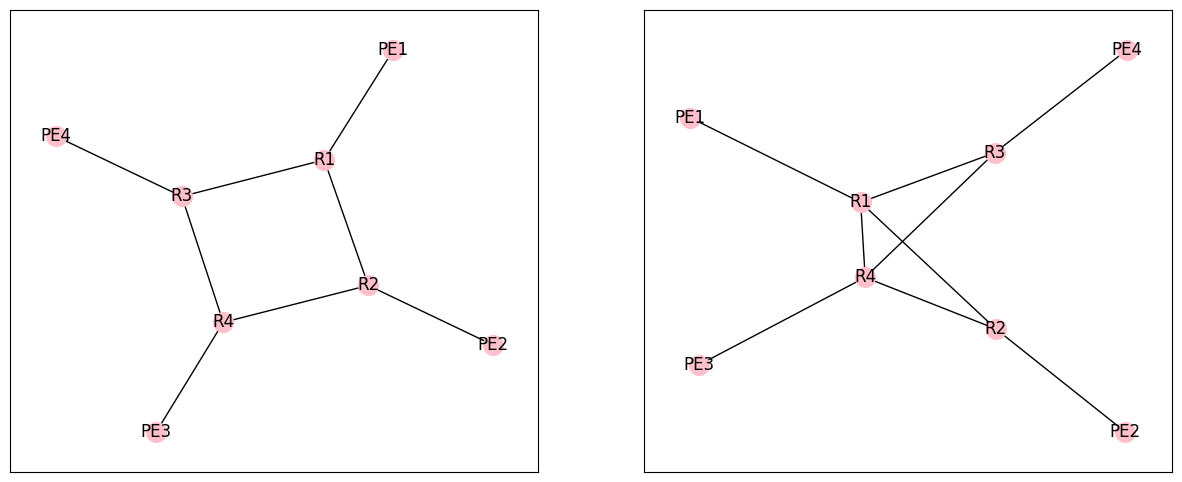

In [12]:
plt.subplots( 1, 2, figsize=(15,6) )
plt.subplot( 1, 2, 1 )
customGraph.drawGraph()
print( customGraph.nodes )
plt.subplot( 1, 2, 2 )
chromosomeGraph.drawGraph()
#print( chromosomeGraph.nodes )

## Métodos Prueba

### Descripción

In [13]:
routers = [ 'R{}'.format(index) for index in range(1,17) ]
labeledEdges = {('R1','R2'):1,('R1','R5'):1,('R2','R3'):1,('R2','R6'):1,('R3','R4'):1,('R3','R7'):1,('R4','R8'):1,
                ('R5','R6'):1,('R5','R9'):1,('R6','R7'):1,('R6','R10'):1,('R7','R8'):1,('R7','R11'):1, ('R8','R12'):1,
                ('R9','R13'):1,('R9','R10'):1,('R10','R11'):1,('R10','R14'):1,('R11','R12'):1, ('R11','R15'):1,('R12','R16'):1,
                ('R13','R14'):1,('R14','R15'):1,('R15','R16'):1}

routers = [ 'R{}'.format(index) for index in range(1,5) ]
labeled_edges_routers = {('R1','R2'):1,('R1','R3'):1,('R2','R4'):1,('R3','R4'):1,}

processing_elements = ['PE{}'.format(index) for index in range(1,5)]
labeled_edges_processing_elements = {('PE1', 'R1'):1, ('PE2', 'R2'):1,('PE3', 'R3'):1,('PE4', 'R4'):1}

### Conversion 

In [14]:
def create_adj_matrix_routers(routers, labeled_edges_routers):
    adj_matrix = np.zeros((len(routers), len(routers)), dtype=int)

    for source_node, destination_node in labeled_edges_routers.copy().keys():
        labeled_edges_routers[(destination_node, source_node)] = labeled_edges_routers[(source_node, destination_node)] if (destination_node, source_node) not in labeled_edges_routers else labeled_edges_routers[(destination_node, source_node)]

    for source_node_index, source_node in enumerate(routers):
        for destination_node_index, destination_node in enumerate(routers):
            if (source_node, destination_node) in labeled_edges_routers:
                adj_matrix[source_node_index][destination_node_index] = 1

    return adj_matrix


def create_adj_matrix_processing_elements(processing_elements, routers, labeled_edges_processing_elements):
    adj_matrix = np.zeros((len(processing_elements), len(routers)), dtype=int)

    for source_node, destination_node in labeled_edges_processing_elements.copy().keys():
        labeled_edges_processing_elements[(destination_node, source_node)] = labeled_edges_processing_elements[(source_node, destination_node)] if (destination_node, source_node) not in labeled_edges_processing_elements else labeled_edges_processing_elements[(destination_node, source_node)]

    for source_node_index, source_node in enumerate(processing_elements):
        for destination_node_index, destination_node in enumerate(routers):
            if (source_node, destination_node) in labeled_edges_processing_elements:
                adj_matrix[source_node_index][destination_node_index] = 1

    return adj_matrix

adj_matrix_routers = create_adj_matrix_routers( routers, labeled_edges_routers)
adj_matrix_processing_elements = create_adj_matrix_processing_elements( processing_elements, routers, labeled_edges_processing_elements )

print( adj_matrix_routers )
print( adj_matrix_processing_elements  )

[[0 1 1 0]
 [1 0 0 1]
 [1 0 0 1]
 [0 1 1 0]]
[[1 0 0 0]
 [0 1 0 0]
 [0 0 1 0]
 [0 0 0 1]]


### Conversion

In [15]:
def create_labeled_edges_routers( adj_matrix_router ):
    routers = ['R{}'.format(index) for index in range(1, adj_matrix_router.shape[0]+1 )]
    
    labeled_edges_routers = {}
    
    for source_node_index in range(adj_matrix_router.shape[0]):
        for destination_node_index in range(adj_matrix_router.shape[0]):
            if adj_matrix_router[source_node_index, destination_node_index] == 1:
                labeled_edges_routers[(routers[source_node_index], routers[destination_node_index])] = 1
    return labeled_edges_routers

def create_labeled_edges_processing_elements(adj_matrix_pe):
    routers = ['R{}'.format(index) for index in range(1, adj_matrix_pe.shape[0]+1 )]
    processing_elements = ['PE{}'.format(index) for index in range(1, adj_matrix_pe.shape[0]+1)]

    labeled_edges_processing_elements = {}

    for source_node_index in range(adj_matrix_pe.shape[0]):
        for destination_node_index in range(adj_matrix_pe.shape[0]):
            if adj_matrix_pe[source_node_index, destination_node_index] == 1:
                labeled_edges_processing_elements[(processing_elements[source_node_index], routers[destination_node_index])] = 1
    return labeled_edges_processing_elements
    
labeled_edges_routers=  create_labeled_edges_routers( adj_matrix_routers )
labeled_edges_processing_elements = create_labeled_edges_processing_elements(  adj_matrix_processing_elements )

print( labeled_edges_routers )
print( labeled_edges_processing_elements )

{('R1', 'R2'): 1, ('R1', 'R3'): 1, ('R2', 'R1'): 1, ('R2', 'R4'): 1, ('R3', 'R1'): 1, ('R3', 'R4'): 1, ('R4', 'R2'): 1, ('R4', 'R3'): 1}
{('PE1', 'R1'): 1, ('PE2', 'R2'): 1, ('PE3', 'R3'): 1, ('PE4', 'R4'): 1}


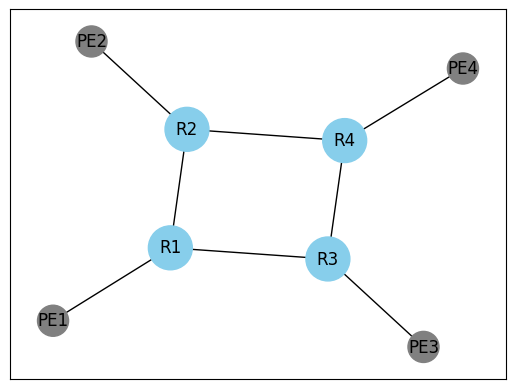

In [16]:
G = nx.Graph()
G.add_nodes_from( routers )
G.add_edges_from( labeled_edges_routers )
G.add_nodes_from( processing_elements )
G.add_edges_from( labeled_edges_processing_elements )

# Configuración de atributos para los nodos
node_attributes = {}
for node in G.nodes:
    if node.startswith('R'):  # Routers
        node_attributes[node] = {'color': 'skyblue', 'size': 1000}
    else:  # Processing Elements
        node_attributes[node] = {'color': 'gray', 'size': 500}

# Dibujo de la red con atributos personalizados
nx.draw_networkx(
    G,
    with_labels=True,
    node_size=[node_attributes[node]['size'] for node in G.nodes],
    node_color=[node_attributes[node]['color'] for node in G.nodes],
    edge_color='black'
)

### Cromosomas

In [17]:
def create_chromosome_standard( adj_matrix_pe ):
  chromosome = np.zeros( (adj_matrix_pe.shape[0]), dtype= int )

  for source_node in range( adj_matrix_pe.shape[0] ):
    for destination_node in range( adj_matrix_pe.shape[0] ) :
      if adj_matrix_pe[source_node,destination_node] == 1:
        chromosome[destination_node] = source_node

  return chromosome

def create_chromosome_custom( adj_matrix_routers ):
  chromosome = np.zeros( (adj_matrix_routers.shape[0]), dtype= int )
  upper_triangular_indices = np.triu_indices(n=adj_matrix_routers.shape[0], k=1)
  chromosome = adj_matrix_routers[upper_triangular_indices]

  return chromosome

chromosome_standard = create_chromosome_standard( adj_matrix_processing_elements )  
print( chromosome_standard )

chromosome_custom = create_chromosome_custom( adj_matrix_routers )  
print( chromosome_custom )

[0 1 2 3]
[1 1 0 0 1 1]


### Mutaciones

In [18]:
def mutation_chromosome_standard( chromosome ):
  chromosome_mutate = chromosome
  idx_1, idx_2 = np.random.choice(len(chromosome), size=2, replace=False)
  chromosome_mutate[idx_1], chromosome_mutate[idx_2] = (chromosome_mutate[idx_2], chromosome_mutate[idx_1])
  
  return chromosome_mutate

def mutation_chromosome_custom( chromosome ):
  chromosome_mutate = chromosome
  index_to_mutation = np.random.choice( len( chromosome ) )
  chromosome_mutate[ index_to_mutation ] = 1 - chromosome[index_to_mutation]
  
  return chromosome_mutate

chromosome_standard_mutate = mutation_chromosome_standard( chromosome_standard)
chromosome_custom_mutate = mutation_chromosome_custom( chromosome_custom )

print( chromosome_standard_mutate )
print( chromosome_custom_mutate )

[2 1 0 3]
[1 0 0 0 1 1]


### Chromosoa a Adj_matrix

---



In [19]:
def create_adj_matrix_routers(chromosome):
  matrix_size = 4
  adj_matrix_routers = np.zeros((matrix_size, matrix_size), dtype=int)

  chromosome_index = 0

  print( chromosome )
  for source_node in range(matrix_size):
    for destination_node in range(source_node + 1, matrix_size):
      adj_matrix_routers[source_node, destination_node] = chromosome[chromosome_index]
      adj_matrix_routers[destination_node, source_node] = chromosome[chromosome_index]
      print( [source_node, destination_node, chromosome[chromosome_index] ] )
      chromosome_index += 1
    
  return adj_matrix_routers

def create_adj_matrix_processing_elements( chromosome ):
  matrix_size = 4
  adj_matrix_processing_elements = np.zeros((matrix_size, matrix_size), dtype=int)

  for destination_node in range( matrix_size ):
    source_node = np.where(chromosome == destination_node)[0][0]
    adj_matrix_processing_elements[source_node, destination_node] = 1
  return adj_matrix_processing_elements   



adj_matrix_routers = create_adj_matrix_routers( chromosome_custom )
adj_matrix_processing_elements = create_adj_matrix_processing_elements( chromosome_standard )
print( adj_matrix_routers )
print( adj_matrix_processing_elements ) 

[1 0 0 0 1 1]
[0, 1, 1]
[0, 2, 0]
[0, 3, 0]
[1, 2, 0]
[1, 3, 1]
[2, 3, 1]
[[0 1 0 0]
 [1 0 0 1]
 [0 0 0 1]
 [0 1 1 0]]
[[0 0 1 0]
 [0 1 0 0]
 [1 0 0 0]
 [0 0 0 1]]


In [20]:
def create_labeled_edges_routers( adj_matrix_router ):
  routers = ['R{}'.format(index) for index in range(1, adj_matrix_router.shape[0]+1 )]

  labeled_edges_routers = {}

  for source_node_index in range(adj_matrix_router.shape[0]):
    for destination_node_index in range(adj_matrix_router.shape[0]):
      if adj_matrix_router[source_node_index, destination_node_index] == 1:
        labeled_edges_routers[(routers[source_node_index], routers[destination_node_index])] = 1
  return labeled_edges_routers

def create_labeled_edges_processing_elements(adj_matrix_pe):
  routers = ['R{}'.format(index) for index in range(1, adj_matrix_pe.shape[0]+1 )]
  processing_elements = ['PE{}'.format(index) for index in range(1, adj_matrix_pe.shape[0]+1)]

  labeled_edges_processing_elements = {}

  for source_node_index in range(adj_matrix_pe.shape[0]):
    for destination_node_index in range(adj_matrix_pe.shape[0]):
      if adj_matrix_pe[source_node_index, destination_node_index] == 1:
        labeled_edges_processing_elements[(processing_elements[source_node_index], routers[destination_node_index])] = 1
  return labeled_edges_processing_elements
    
labeled_edges_routers = create_labeled_edges_routers( adj_matrix_routers )
labeled_edges_processing_elements = create_labeled_edges_processing_elements( adj_matrix_processing_elements )

print( labeled_edges_routers )
print( labeled_edges_processing_elements )

{('R1', 'R2'): 1, ('R2', 'R1'): 1, ('R2', 'R4'): 1, ('R3', 'R4'): 1, ('R4', 'R2'): 1, ('R4', 'R3'): 1}
{('PE1', 'R3'): 1, ('PE2', 'R2'): 1, ('PE3', 'R1'): 1, ('PE4', 'R4'): 1}


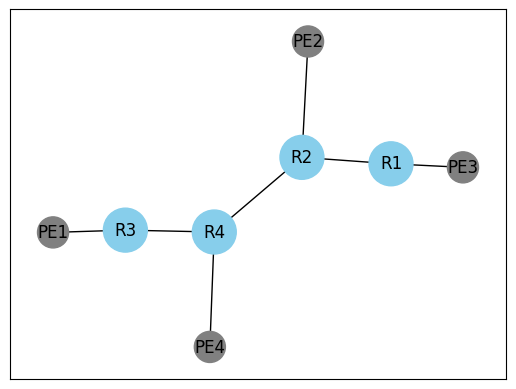

In [21]:
G = nx.Graph()
G.add_nodes_from( routers )
G.add_edges_from( labeled_edges_routers )
G.add_nodes_from( processing_elements )
G.add_edges_from( labeled_edges_processing_elements )

# Configuración de atributos para los nodos
node_attributes = {}
for node in G.nodes:
    if node.startswith('R'):  # Routers
        node_attributes[node] = {'color': 'skyblue', 'size': 1000}
    else:  # Processing Elements
        node_attributes[node] = {'color': 'gray', 'size': 500}

# Dibujo de la red con atributos personalizados
nx.draw_networkx(
    G,
    with_labels=True,
    node_size=[node_attributes[node]['size'] for node in G.nodes],
    node_color=[node_attributes[node]['color'] for node in G.nodes],
    edge_color='black')

# Grafos

## <font color = 'brown'> Clase Grafo </font>

In [22]:
class Graph():
  def __init__( self, *args ):

    descriptorGraph = DescriptorGraph( *args )

    self.routers               = descriptorGraph.routers
    self.labeled_edges_routers = descriptorGraph.labeled_edges_routers
    self.cores                 = descriptorGraph.cores
    self.labeled_edges_cores   = descriptorGraph.labeled_edges_cores

    self.adj_matrix_routers    = descriptorGraph.adj_matrix_routers
    self.adj_matrix_cores      = descriptorGraph.adj_matrix_cores

    self.chromosome_custom     = list(descriptorGraph.chromosome_custom)
    self.chromosome_standard   = list(descriptorGraph.chromosome_standard)



  def selection( self, chromosome ):
    print( 'Selection' )

  def mutation( self, chromosome ): 
    print( 'Mutation Algoritmos geneticos' )
    return chromosome.mutation( )

  def crossover( self, parent_1, parent_2 ):
    print( 'Crossover' )  
    return parent_1.crossover( parent_2 )



## DescriptorGraph

In [23]:
class DescriptorGraph():
  def __init__( self, *args ):
    self.routers               = None
    self.labeled_edges_routers = None
    self.cores                 = None
    self.labeled_edges_cores   = None

    self.adj_matrix_routers    = None
    self.adj_matrix_cores      = None

    self.chromosome_custom     = None
    self.chromosome_standard   = None

    if len( args ) == 1: 
      undirectGraph = args[0]
      self.routers               = undirectGraph.routers
      self.labeled_edges_routers = undirectGraph.labeled_edges_routers
      self.cores                 = undirectGraph.cores
      self.labeled_edges_cores   = undirectGraph.labeled_edges_cores

      self.adj_matrix_routers    = undirectGraph.adj_matrix_routers
      
      self.adj_matrix_cores      = undirectGraph.adj_matrix_cores

      self.chromosome_custom     = undirectGraph.chromosome_custom
      self.chromosome_standard   = undirectGraph.chromosome_standard

    elif len( args ) == 2:
      chromosomeCustom   = args[0]
      chromosomeStandard = args[1]
      self.routers               = chromosomeCustom.routers
      self.labeled_edges_routers = chromosomeCustom.labeled_edges_routers
      self.cores                 = chromosomeStandard.cores
      self.labeled_edges_cores   = chromosomeStandard.labeled_edges_cores

      self.adj_matrix_routers    = chromosomeCustom.adj_matrix_routers
      self.adj_matrix_cores      = chromosomeStandard.adj_matrix_cores

      self.chromosome_custom     = chromosomeCustom.chromosome
      self.chromosome_standard   = chromosomeStandard.chromosome 

    else:
      raise ValueError("Invalid number of arguments") 

    

## <font color='orange'> Clase UndirectGraph </font>

In [24]:
class UndirectGraph( ):
  def __init__( self, routers, labeled_edges_routers, cores, labeled_edges_cores ):
    self.routers               = routers
    self.labeled_edges_routers = labeled_edges_routers
    self.cores                 = cores
    self.labeled_edges_cores   = labeled_edges_cores

    self.adj_matrix_routers    = self.create_adj_matrix_routers( self.routers, self.labeled_edges_routers )
    self.adj_matrix_cores      = self.create_adj_matrix_cores( self.cores, self.labeled_edges_cores )
    
    self.chromosome_custom     = self.create_chromosome_custom( self.adj_matrix_routers )
    self.chromosome_standard   = self.create_chromosome_standard( self.adj_matrix_cores )


  def create_adj_matrix_routers( self, routers, labeled_edge_routers ):
    
    for source_router, destination_router in labeled_edge_routers.copy().keys():
      if (destination_router, source_router) not in self.labeled_edges_routers:
        self.labeled_edges_routers[(destination_router, source_router)] = self.labeled_edges_routers[(source_router, destination_router)]

    adj_matrix_routers = np.zeros( (len(routers), len(routers)), dtype=int )

    for source_router_index, source_router in enumerate( routers ):
      for destination_router_index, destination_router in enumerate( routers ):
        if( source_router, destination_router) in self.labeled_edges_routers:
          adj_matrix_routers[source_router_index, destination_router_index] = 1

    return adj_matrix_routers


  def create_adj_matrix_cores( self, cores, labeled_edges_cores ):

    for source_core, destination_router in labeled_edges_cores.copy().keys():
      if (destination_router, source_core) not in self.labeled_edges_cores:
        self.labeled_edges_cores[(destination_router, source_core)] = self.labeled_edges_cores[(source_core, destination_router)]

    adj_matrix_cores = np.zeros( (len(cores), len(routers)), dtype=int )

    for source_core_index, source_router in enumerate( cores ):
      for destination_router_index, destination_router in enumerate( routers ):
        if( source_router, destination_router) in self.labeled_edges_cores:
          adj_matrix_cores[source_core_index, destination_router_index] = 1

    return adj_matrix_cores


  def create_chromosome_custom( self, adj_matrix_routers ):

    chromosome_custom = np.zeros( (adj_matrix_routers.shape[0]), dtype= int )
    upper_triangular_indices = np.triu_indices(n=adj_matrix_routers.shape[0], k=1)
    chromosome_custom = adj_matrix_routers[upper_triangular_indices]

    return chromosome_custom  


  def create_chromosome_standard( self, adj_matrix_cores ): 
    
    chromosome_standard = np.zeros( (adj_matrix_cores.shape[0]), dtype= int )

    for source_core in range( adj_matrix_cores.shape[0] ):
      for destination_router in range( adj_matrix_cores.shape[0] ):
        if adj_matrix_cores[source_core, destination_router] == 1:
          chromosome_standard[destination_router] = source_core
    
    return chromosome_standard


## <font color='orange'> Clase ChromosomeCustom</font> 

In [25]:
class ChromosomeCustom( ):
  def __init__( self, chromosome ):
    self.adj_matrix_routers    = self.create_adj_matrix_routers( chromosome )
    self.chromosome            = chromosome
    self.routers               = self.create_routers( chromosome )
    self.labeled_edges_routers = self.create_labeled_edges_routers( self.routers, self.adj_matrix_routers )
   

  def create_routers( self, chromosome ):

    def get_number_of_routers( chromosome ):
      n = (1 + math.sqrt(1 + 8 * len(chromosome))) / 2
      return math.floor(n) if n % 1 < 0.5 else math.ceil(n)
  
    number_of_routers = get_number_of_routers( chromosome )
    routers = ['R{}'.format(index) for index in range(1, number_of_routers+1 )]

    return routers

  def create_labeled_edges_routers( self, routers, adj_matrix_routers ):
    labeled_edges_routers = {}

    for source_router_index in range( adj_matrix_routers.shape[0] ):
      for destination_router_index in range( adj_matrix_routers.shape[0] ):
        if adj_matrix_routers[source_router_index, destination_router_index] == 1:
          labeled_edges_routers[(routers[source_router_index],routers[destination_router_index])] = 1
          
    return labeled_edges_routers

  def create_adj_matrix_routers( self, chromosome ):

    def get_number_of_routers( chromosome ):
      n = (1 + math.sqrt(1 + 8 * len(chromosome))) / 2
      return math.floor(n) if n % 1 < 0.5 else math.ceil(n)

    number_of_routers = get_number_of_routers( chromosome )

    adj_matrix_routers = np.zeros((number_of_routers,number_of_routers), dtype=int)
    chromosome_index = 0 
      
    for source_router in range( number_of_routers ):
      for destination_router in range( source_router + 1, number_of_routers ):
        adj_matrix_routers[source_router, destination_router] = chromosome[chromosome_index]
        adj_matrix_routers[destination_router, source_router] = chromosome[chromosome_index]
        chromosome_index += 1
    return adj_matrix_routers


  def crossover( self, parent_2 ):
    print( 'Crossover Custom' )
    gene_pairs = list( zip(self.chromosome, parent_2.chromosome) )  
    child = tuple( np.random.choice(gene) for gene in gene_pairs )
    print( child )
    return child


  def mutation( self ):
    print( 'Mutation Chromosome Custom' )
    mutate_chromosome = self.chromosome
    index_to_mutation = np.random.choice( len( mutate_chromosome ) )
    mutate_chromosome[index_to_mutation] = 1 -mutate_chromosome[index_to_mutation]
    return mutate_chromosome

## <font color='orange'> Clase ChromosomeStandard</font> 

In [26]:
class ChromosomeStandard( ):
  def __init__( self, chromosome ):
    self.cores               = self.create_cores( chromosome )
    
    self.adj_matrix_cores    = self.create_adj_matrix_cores( chromosome )
    self.labeled_edges_cores = self.create_labeled_edges_cores( chromosome, self.adj_matrix_cores )

    self.chromosome = chromosome

  def create_cores( self, chromosome ):
   
    cores = ['PE{}'.format(index) for index in range(1, len(chromosome) + 1) ]
   
    return cores

  def create_labeled_edges_cores( self, chromosome, adj_matrix_cores ):
    
    routers = ['R{}'.format(index) for index in range(1, len(chromosome) +1 )]
    cores   = ['PE{}'.format(index) for index in range(1, adj_matrix_cores.shape[0] +1 )]
    
    labeled_edges_cores = {} 

    for source_core_index in range( adj_matrix_cores.shape[0] ):
      for destination_router_index in range( adj_matrix_cores.shape[0] ):
        if adj_matrix_cores[source_core_index, destination_router_index] == 1:
          labeled_edges_cores[(cores[source_core_index], routers[destination_router_index])] = 1
          
    return labeled_edges_cores  

  def create_adj_matrix_cores( self, chromosome ):
    
    number_of_cores = len( chromosome )  
    adj_matrix_cores = np.zeros( (number_of_cores, number_of_cores), dtype=int )

    for destination_router in range( number_of_cores ):
      source_core = chromosome.index(destination_router)
      adj_matrix_cores[source_core, destination_router] = 1
      
    return adj_matrix_cores  
  

  def mutation( self ):
    mutate_chromosome = self.chromosome
    idx_1, idx_2 = np.random.choice(len(mutate_chromosome), size=2, replace=False)
    mutate_chromosome[idx_1], mutate_chromosome[idx_2] = (mutate_chromosome[idx_2],mutate_chromosome[idx_1])
    return mutate_chromosome

## <font color='lime'> Pruebas Clases </font>

### Clase UndirectGraph

In [27]:
routers = [ 'R{}'.format(index) for index in range(1,5) ]
labeled_edges_routers = {('R1','R2'):1,('R1','R3'):1,('R2','R4'):1,('R3','R4'):1,}

cores = ['PE{}'.format(index) for index in range(1,5)]
labeled_edges_cores = {('PE1', 'R1'):1, ('PE2', 'R2'):1,('PE3', 'R3'):1,('PE4', 'R4'):1}


In [28]:
undirectGraph = UndirectGraph( routers, labeled_edges_routers, cores, labeled_edges_cores )
descriptorGraph = DescriptorGraph( undirectGraph )  

UndirectGraph_Graph = Graph( descriptorGraph )

### Clase Chromosome

In [29]:
chromosomeCustom   = ChromosomeCustom( [1, 1, 0, 0, 1, 1] )
chromosomeStandard = ChromosomeStandard( [0, 1, 2, 3] )

In [30]:
Chromosome_Graph = Graph( chromosomeCustom, chromosomeStandard)

In [31]:
print( '=' * 30 )
print( 'Routers')
print( UndirectGraph_Graph.routers )
print( '-' * 30 )
print( 'Edges Routers' )
print( UndirectGraph_Graph.labeled_edges_routers )
print( '-' * 30 )
print( 'Matrix adyacente routers' )
print( UndirectGraph_Graph.adj_matrix_routers )
print( '-' * 30 )
print( 'Chromosoma Custom' )
print( UndirectGraph_Graph.chromosome_custom  )
print( '-' * 30 )

print( UndirectGraph_Graph.cores )
print( UndirectGraph_Graph.labeled_edges_cores )
print( UndirectGraph_Graph.adj_matrix_cores )
print( UndirectGraph_Graph.chromosome_standard )
print( '=' * 30 )

print( '=' * 30 )
print( Chromosome_Graph.routers )
print( Chromosome_Graph.labeled_edges_routers )
print( Chromosome_Graph.adj_matrix_routers )
print( Chromosome_Graph.chromosome_custom )

print( Chromosome_Graph.cores )
print( Chromosome_Graph.labeled_edges_cores )
print( Chromosome_Graph.adj_matrix_cores )
print( Chromosome_Graph.chromosome_standard )
print( '=' * 30 )

Routers
['R1', 'R2', 'R3', 'R4']
------------------------------
Edges Routers
{('R1', 'R2'): 1, ('R1', 'R3'): 1, ('R2', 'R4'): 1, ('R3', 'R4'): 1, ('R2', 'R1'): 1, ('R3', 'R1'): 1, ('R4', 'R2'): 1, ('R4', 'R3'): 1}
------------------------------
Matrix adyacente routers
[[0 1 1 0]
 [1 0 0 1]
 [1 0 0 1]
 [0 1 1 0]]
------------------------------
Chromosoma Custom
[1, 1, 0, 0, 1, 1]
------------------------------
['PE1', 'PE2', 'PE3', 'PE4']
{('PE1', 'R1'): 1, ('PE2', 'R2'): 1, ('PE3', 'R3'): 1, ('PE4', 'R4'): 1, ('R1', 'PE1'): 1, ('R2', 'PE2'): 1, ('R3', 'PE3'): 1, ('R4', 'PE4'): 1}
[[1 0 0 0]
 [0 1 0 0]
 [0 0 1 0]
 [0 0 0 1]]
[0, 1, 2, 3]
['R1', 'R2', 'R3', 'R4']
{('R1', 'R2'): 1, ('R1', 'R3'): 1, ('R2', 'R1'): 1, ('R2', 'R4'): 1, ('R3', 'R1'): 1, ('R3', 'R4'): 1, ('R4', 'R2'): 1, ('R4', 'R3'): 1}
[[0 1 1 0]
 [1 0 0 1]
 [1 0 0 1]
 [0 1 1 0]]
[1, 1, 0, 0, 1, 1]
['PE1', 'PE2', 'PE3', 'PE4']
{('PE1', 'R1'): 1, ('PE2', 'R2'): 1, ('PE3', 'R3'): 1, ('PE4', 'R4'): 1}
[[1 0 0 0]
 [0 1 0 0]
 [0

In [32]:
G = nx.Graph()
G.add_nodes_from( routers )
G.add_edges_from( labeled_edges_routers )
G.add_nodes_from( cores )
G.add_edges_from( labeled_edges_cores )

G_UndirectGraph = nx.Graph()
G_UndirectGraph.add_nodes_from( UndirectGraph_Graph.routers )
G_UndirectGraph.add_edges_from( UndirectGraph_Graph.labeled_edges_routers )
G_UndirectGraph.add_nodes_from( UndirectGraph_Graph.cores )
G_UndirectGraph.add_edges_from( UndirectGraph_Graph.labeled_edges_cores )

G_Chromosome = nx.Graph()
G_Chromosome.add_nodes_from( Chromosome_Graph.routers )
G_Chromosome.add_edges_from( Chromosome_Graph.labeled_edges_routers )
G_Chromosome.add_nodes_from( Chromosome_Graph.cores )
G_Chromosome.add_edges_from( Chromosome_Graph.labeled_edges_cores )
# Configuración de atributos para los nodos
node_attributes = {}
for node in G.nodes:
    if node.startswith('R'):  # Routers
        node_attributes[node] = {'color': 'skyblue', 'size': 1000}
    else:  # Processing Elements
        node_attributes[node] = {'color': 'gray', 'size': 500}


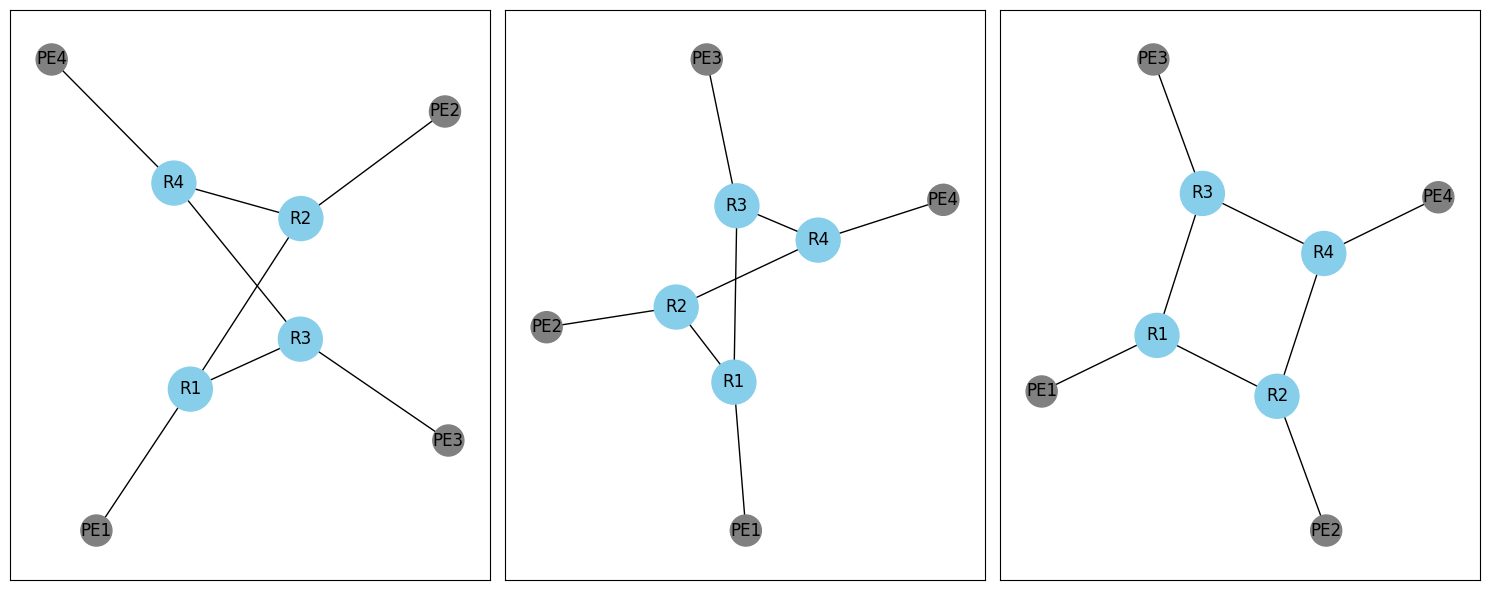

In [33]:
plt.subplots( 1, 3, figsize=(15, 6) )

plt.subplot( 1, 3, 1 )
nx.draw_networkx(
    G,
    with_labels=True,
    node_size=[node_attributes[node]['size'] for node in G.nodes],
    node_color=[node_attributes[node]['color'] for node in G.nodes],
    edge_color='black')

plt.subplot( 1, 3, 2 )
nx.draw_networkx(
    G_UndirectGraph,
    with_labels=True,
    node_size=[node_attributes[node]['size'] for node in G.nodes],
    node_color=[node_attributes[node]['color'] for node in G.nodes],
    edge_color='black')

plt.subplot( 1, 3, 3 )
nx.draw_networkx(
    G_Chromosome,
    with_labels=True,
    node_size=[node_attributes[node]['size'] for node in G.nodes],
    node_color=[node_attributes[node]['color'] for node in G.nodes],
    edge_color='black')

plt.tight_layout()
plt.show()


### Mutaciones

In [34]:
def mutation( chromosome ):
  print( chromosome.chromosome )
  print( chromosome.mutation()  )

mutation( chromosomeCustom  ) 
mutation( chromosomeStandard )

mutate_Graph = Graph( ChromosomeCustom(chromosomeGraph.chromosome_custom), ChromosomeStandard(chromosomeGraph.chromosome_standard) )

[1, 1, 0, 0, 1, 1]
Mutation Chromosome Custom
[1, 1, 0, 1, 1, 1]
[0, 1, 2, 3]
[0, 2, 1, 3]


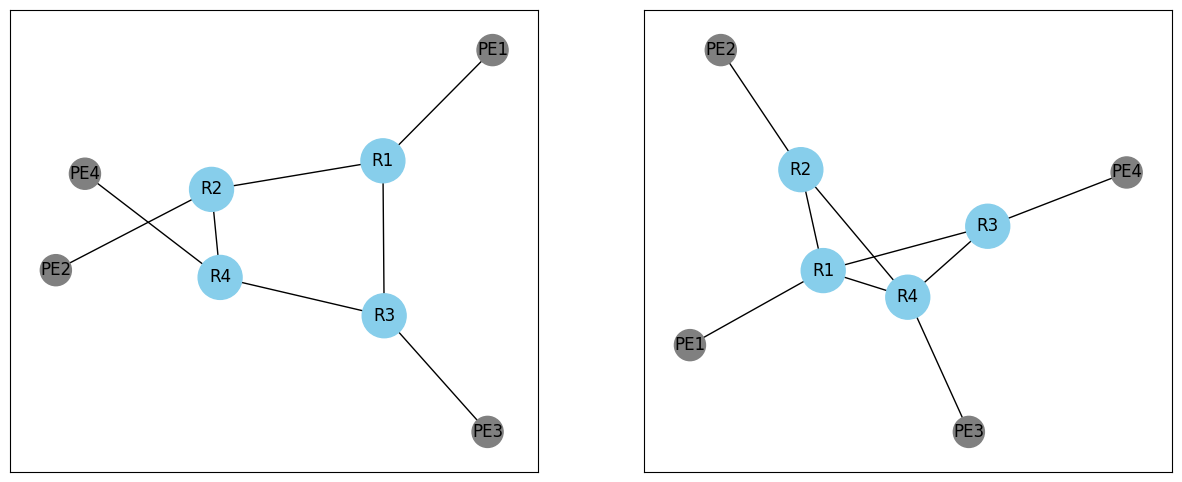

In [35]:
G_mutate = nx.Graph()
G_mutate.add_nodes_from( mutate_Graph.routers )
G_mutate.add_edges_from( mutate_Graph.labeled_edges_routers )
G_mutate.add_nodes_from( mutate_Graph.cores )
G_mutate.add_edges_from( mutate_Graph.labeled_edges_cores )

# Configuración de atributos para los nodos
node_attributes = {}
for node in G_mutate.nodes:
    if node.startswith('R'):  # Routers
        node_attributes[node] = {'color': 'skyblue', 'size': 1000}
    else:  # Processing Elements
        node_attributes[node] = {'color': 'gray', 'size': 500}

plt.subplots( 1, 2, figsize=(15, 6) )

plt.subplot( 1, 2, 1 )
nx.draw_networkx(
    G,
    with_labels=True,
    node_size=[node_attributes[node]['size'] for node in G.nodes],
    node_color=[node_attributes[node]['color'] for node in G.nodes],
    edge_color='black')

plt.subplot( 1, 2, 2 )
nx.draw_networkx(
    G_mutate,
    with_labels=True,
    node_size=[node_attributes[node]['size'] for node in G.nodes],
    node_color=[node_attributes[node]['color'] for node in G.nodes],
    edge_color='black')



## Crossover

# <font color='yellow'> Algortimos Geneticos </font>

## Clase GeneticAlgoritm

In [41]:
class GeneticAlgorithm():
  def __init__( self, initial_individual = None ):
    self.initial_individual = initial_individual
    self.population = []

  def generate_random_population( self, initial_individual ):
    
    population = []

    if initial_individual is not None:
      self.population.append( initial_individual )

  def selection( self ):
    None

  def crossover( self ):  
    
    children_per_pair_parents = 1
    indices_parents = np.random.choice( len(self.population), size=(len(self.population) // 2, 2), replace=False )
    

    for index_pair in indices_parents:
      parent_1 = self.population[index_pair[0]]
      parent_2 = self.population[index_pair[1]]

      for _ in range( children_per_pair_parents ):
        #chromosome_crossover = parent_1.crossover( ChromosomeCustom(parent_1.chromosome_custom), ChromosomeCustom(parent_2.chromosome_custom)  )
        #child = Graph( ChromosomeCustom( chromosome_crossover ), ChromosomeStandard( parent_1.chromosome_standard ) )
        #self.population.append( child )
        None

  def mutation_standard( self ):
    #self.cores_routers_graph
    None

  def mutation( self ):

    number_of_individuals_to_mutate = 1
    indices_of_individual_to_mutate = np.random.choice( len(self.population), size= number_of_individuals_to_mutate, replace = True )

    for index_individual in indices_of_individual_to_mutate:

      individual =  self.population[index_individual]
      #individual_mutate = individual.mutation( ChromosomeCustom(individual.chromosome_custom)  )
      individual_mutate = individual.mutation( ChromosomeStandard( individual.chromosome_standard  ) )
      #self.population.append( Graph( ChromosomeCustom(individual.chromosome_custom), ChromosomeStandard(individual.chromosome_standard) ) )
      self.population.append( Graph( ChromosomeCustom(individual.chromosome_custom), ChromosomeStandard(individual_mutate) ) )

  def initialize( self ):
    self.generate_random_population( self.initial_individual )

  def solve( self ):
    self.initialize()
    self.mutation()
    self.crossover()

## Configuracion Graficas

In [42]:
# Configuración de atributos para los nodos
def configure_node_attributes(G):
    node_attributes = {}
    for node in G.nodes:
        if node.startswith('R'):  # Routers
            node_attributes[node] = {'color': 'skyblue', 'size': 1000}
        else:  # Processing Elements
            node_attributes[node] = {'color': 'gray', 'size': 500}
    return node_attributes

# Graficar población en subplots
def plot_population(population):
    num_individuals = len(population)
    num_cols = 3  # Número de columnas en los subplots
    num_rows = (num_individuals - 1) // num_cols + 1  # Número de filas en los subplots
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 8))
    
    if num_rows == 1:
        axes = np.expand_dims(axes, axis=0)
    
    current_ax = 0

    for i, individual in enumerate(population):
        row = current_ax // num_cols
        col = current_ax % num_cols
        ax = axes[row, col]

        G = nx.Graph()
        G.add_nodes_from(individual.routers)
        G.add_edges_from(individual.labeled_edges_routers)
        G.add_nodes_from(individual.cores)
        G.add_edges_from(individual.labeled_edges_cores)

        node_attributes = configure_node_attributes(G)

        ax.set_title(f'Architecture #{i+1}')
        nx.draw_networkx(
            G,
            with_labels=True,
            node_size=[node_attributes[node]['size'] for node in G.nodes],
            node_color=[node_attributes[node]['color'] for node in G.nodes],
            edge_color='black',
            ax=ax)

        current_ax += 1

    # Eliminar subgráficos no utilizados
    for i in range(len(population), num_rows * num_cols):
        row = current_ax // num_cols
        col = current_ax % num_cols
        axes[row, col].axis('off')
        current_ax += 1

    plt.tight_layout()
    plt.show()


## Prueba Clase

[]
Mutation Algoritmos geneticos


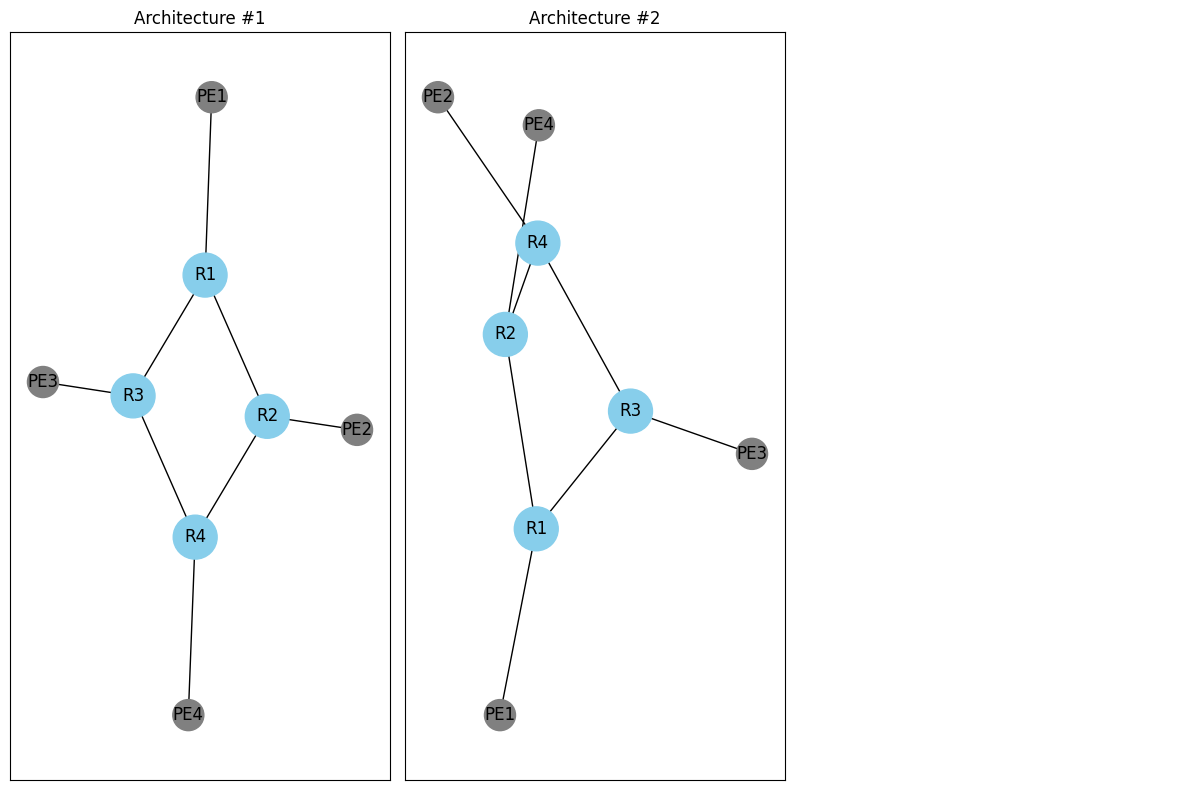

2


In [43]:
GA = GeneticAlgorithm( UndirectGraph_Graph )
print(GA.population)

GA.solve()
plot_population(GA.population)
print( len( GA.population ))

## Configuración Mesh 

### Routers

In [44]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np

# Configuración de atributos y posiciones para los nodos
def configure_node_attributes(G):
    node_attributes = {}
    node_positions = {}

    # Número de routers y dimensiones de la malla
    num_routers = len([node for node in G.nodes if node.startswith('R')])
    num_rows = int(np.sqrt(num_routers))
    num_cols = int(np.ceil(num_routers / num_rows))

    for i, node in enumerate(G.nodes):
        if node.startswith('R'):  # Routers
            node_attributes[node] = {'color': 'skyblue', 'size': 1000}
            row = i // num_cols
            col = i % num_cols
            node_positions[node] = (col, -row)  # Invertir el eje y para que los routers superiores estén arriba
        else:  # Processing Elements
            node_attributes[node] = {'color': 'gray', 'size': 500}
            router = node.split('PE')[1]  # Obtener el número de router al que está conectado el PE
            router_pos = node_positions[f'R{router}']  # Obtener la posición del router correspondiente
            pe_pos = (router_pos[0] - 0.2, router_pos[1] - 0.2)  # Posición relativa al router (un poco a la izquierda y abajo)
            node_positions[node] = pe_pos

    return node_attributes, node_positions

# Graficar población en subplots
def plot_population(population):
    num_individuals = len(population)
    num_cols = 3  # Número de columnas en los subplots
    num_rows = (num_individuals - 1) // num_cols + 1  # Número de filas en los subplots
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 8))

    if num_rows == 1:
        axes = np.expand_dims(axes, axis=0)

    current_ax = 0

    for i, individual in enumerate(population):
        row = current_ax // num_cols
        col = current_ax % num_cols
        ax = axes[row, col]

        G = nx.Graph()
        G.add_nodes_from(individual.routers)
        G.add_edges_from(individual.labeled_edges_routers)
        G.add_nodes_from(individual.cores)
        G.add_edges_from(individual.labeled_edges_cores)

        node_attributes, node_positions = configure_node_attributes(G)

        ax.set_title(f'Architecture #{i+1}')
        nx.draw_networkx(
            G,
            pos=node_positions,  # Utilizar las posiciones personalizadas
            with_labels=True,
            node_size=[node_attributes[node]['size'] for node in G.nodes],
            node_color=[node_attributes[node]['color'] for node in G.nodes],
            edge_color='black',
            ax=ax)

        current_ax += 1

    # Eliminar subgráficos no utilizados
    for i in range(len(population), num_rows * num_cols):
        row = current_ax // num_cols
        col = current_ax % num_cols
        axes[row, col].axis('off')
        current_ax += 1

    plt.tight_layout()
    plt.show()


### Routers y Cores

In [45]:

import networkx as nx
import matplotlib.pyplot as plt
import numpy as np


# Configuración de atributos y posiciones para los nodos
def configure_node_attributes(G, labeled_edges_cores):
    node_attributes = {}
    node_positions = {}

    # Número de routers y dimensiones de la malla
    num_routers = len([node for node in G.nodes if node.startswith('R')])
    num_rows = int(np.sqrt(num_routers))
    num_cols = int(np.ceil(num_routers / num_rows))

    for i, node in enumerate(G.nodes):
        if node.startswith('R'):  # Routers
            node_attributes[node] = {'color': 'skyblue', 'size': 1000}
            row = i // num_cols
            col = i % num_cols
            node_positions[node] = (col, -row)  # Invertir el eje y para que los routers superiores estén arriba
        else:  # Processing Elements
            node_attributes[node] = {'color': 'gray', 'size': 500}

            router = get_router_by_pe(node, labeled_edges_cores)  # Obtener el número de router al que está conectado el PE
            if router is None:
                continue  # Si no se encuentra el router, pasar al siguiente procesador

            router_pos = node_positions[router]  # Obtener la posición del router correspondiente
            pe_pos = (router_pos[0] - 0.2, router_pos[1] - 0.2)  # Posición relativa al router (un poco a la izquierda y abajo)
            node_positions[node] = pe_pos

    return node_attributes, node_positions

# Obtener el router al que está conectado el procesador
def get_router_by_pe(processor, labeled_edges_cores):
    for (pe, router), _ in labeled_edges_cores.items():
        if pe == processor:
            return router
    return None

# Graficar población en subplots
def plot_population(population):
    num_individuals = len(population)
    num_cols = 3  # Número de columnas en los subplots
    num_rows = (num_individuals - 1) // num_cols + 1  # Número de filas en los subplots
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 8))

    if num_rows == 1:
        axes = np.expand_dims(axes, axis=0)

    current_ax = 0

    for i, individual in enumerate(population):
        row = current_ax // num_cols
        col = current_ax % num_cols
        ax = axes[row, col]

        G = nx.Graph()
        G.add_nodes_from(individual.routers)
        G.add_edges_from(individual.labeled_edges_routers)
        G.add_nodes_from(individual.cores)
        G.add_edges_from(individual.labeled_edges_cores)

 
        node_attributes, node_positions = configure_node_attributes(G, individual.labeled_edges_cores)

        ax.set_title(f'Architecture #{i+1}')
        nx.draw_networkx(
            G,
            pos=node_positions,  # Utilizar las posiciones personalizadas
            with_labels=True,
            node_size=[node_attributes[node]['size'] for node in G.nodes],
            node_color=[node_attributes[node]['color'] for node in G.nodes],
            edge_color='black',
            ax=ax)

        current_ax += 1

    # Eliminar subgráficos no utilizados
    for i in range(len(population), num_rows * num_cols):
        row = current_ax // num_cols
        col = current_ax % num_cols
        axes[row, col].axis('off')
        current_ax += 1

    plt.tight_layout()
    plt.show()


### Prueba

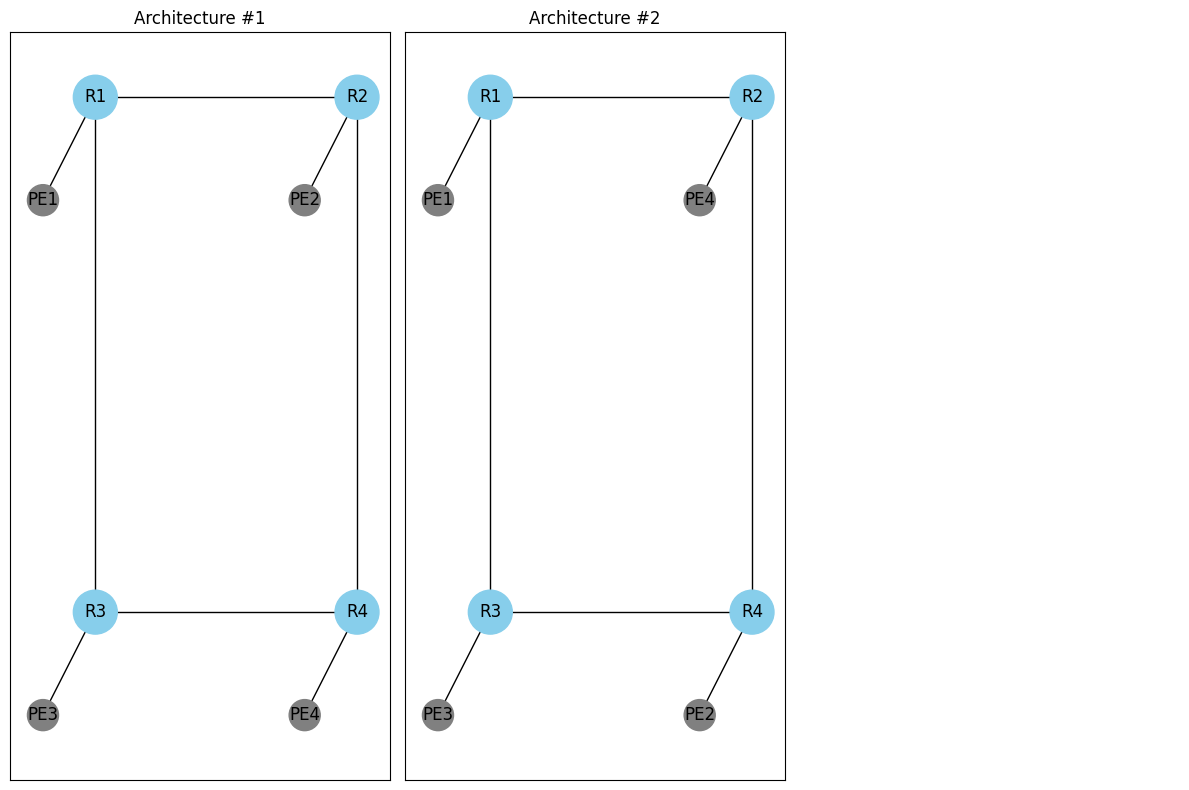

In [46]:
plot_population(GA.population)

# Crossover


Number of kid: 1
Selected Router: [7], Selected Core: [7]
Adjacent Routers to Router [7]: [4, 6, 8]
Swap Router 1:[4], Swap Core 1: [4]
Cores with communication to [7] in Core Graph: [3, 4, 6, 8]
Cores [4, 4] to swap Routers [4, 4]

Number of kid: 2
Selected Router: [3], Selected Core: [3]
Adjacent Routers to Router [3]: [0, 4, 6]
Swap Router 1:[0], Swap Core 1: [0]
Cores with communication to [3] in Core Graph: [6, 7]
Cores [0, 6] to swap Routers [0, 6]

Number of kid: 3
Selected Router: [4], Selected Core: [4]
Adjacent Routers to Router [4]: [1, 3, 5, 7]
Swap Router 1:[5], Swap Core 1: [5]
Cores with communication to [4] in Core Graph: [0, 2, 7, 8]
Cores [5, 0] to swap Routers [5, 6]


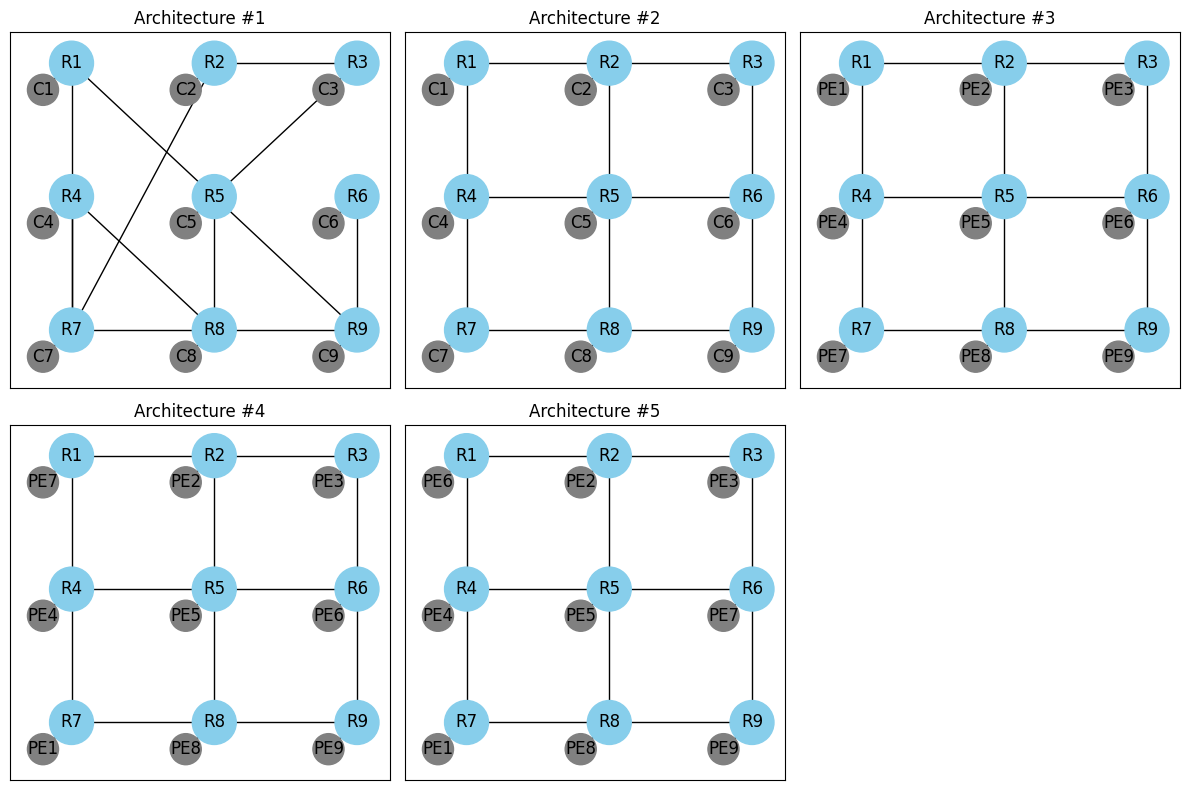

In [96]:
routers = [ 'R{}'.format(index) for index in range(1,10) ]
labeled_edges_routers = {('R1','R2'):1,('R1','R4'):1,('R2','R3'):1,('R2','R5'):1,('R3','R6'):1,
                         ('R4','R5'):1,('R4','R7'):1,('R5','R6'):1,('R5','R8'):1,('R6','R9'):1,
                         ('R7','R8'):1,('R8','R9'):1 }

cores = ['C{}'.format(index) for index in range(1,10)]
labeled_edges_cores = {('C1', 'R1'):1, ('C2', 'R2'):1, ('C3','R3'):1, ('C4', 'R4'):1,('C5','R5'):1, ('C6','R6'):1,('C7', 'R7'):1,('C8', 'R8'):1, ('C9','R9'):1 }

topology = Graph( UndirectGraph( routers, labeled_edges_routers, cores, labeled_edges_cores ) )



routers = [ 'R{}'.format(index) for index in range(1,10) ]
labeled_edges_routers = {('R1','R7'):1,('R1','R5'):1,('R2','R3'):1,('R2','R7'):1,('R3','R5'):1,
                         ('R4','R7'):1,('R4','R8'):1,('R5','R9'):1,('R5','R8'):1,('R6','R9'):1,
                         ('R7','R8'):1,('R8','R9'):1 }

cores = ['C{}'.format(index) for index in range(1,9)]
labeled_edges_cores = {('C1', 'R1'):1, ('C2', 'R2'):1, ('C3','R3'):1, ('C4', 'R4'):1,('C5','R5'):1, ('C6','R6'):1,('C7', 'R7'):1,('C8', 'R8'):1, ('C9','R9'):1 }

topology_tdg = Graph( UndirectGraph( routers, labeled_edges_routers, cores, labeled_edges_cores ) )

def crossover(topology_tdg, topology):

    kid_chromosome = []
    kid_chromosome.append( topology.chromosome_standard )

    kid_graph = []


    number_of_kids = 3

    for kid in range(1, number_of_kids+1 ):

      print( f'\nNumber of kid: {kid}'  )

      select_router = np.random.choice(range(len(topology.routers)))
      select_core = kid_chromosome[kid-1][select_router]

      print(f"Selected Router: [{select_router}], Selected Core: [{select_core}]")

      adjacent_routers = [i for i, adj_value in enumerate(topology.adj_matrix_routers[select_router]) if adj_value != 0]
      
      print(f"Adjacent Routers to Router [{select_router}]: {adjacent_routers}")

      swap_router_1 = np.random.choice(adjacent_routers)
      swap_core_1 = topology.chromosome_standard[swap_router_1]
      
      print(f"Swap Router 1:[{swap_router_1}], Swap Core 1: [{swap_core_1}]")

      communicating_cores = [i for i, adj_value in enumerate(topology_tdg.adj_matrix_routers[select_core]) if adj_value != 0]
      
      print(f"Cores with communication to [{select_core}] in Core Graph: {communicating_cores}")

      swap_core_2 = np.random.choice(communicating_cores)


      kid_chromosome.append( kid_chromosome[kid-1] )

      idx_1 = kid_chromosome[kid].index(swap_core_1)
      idx_2 = kid_chromosome[kid].index(swap_core_2)


      print( f'Cores [{swap_core_1}, {swap_core_2}] to swap Routers [{idx_1}, {idx_2}]')

      kid_chromosome[kid][idx_1], kid_chromosome[kid][idx_2] = kid_chromosome[kid-1][idx_2], kid_chromosome[kid-1][idx_1]

      kid_graph.append( Graph(ChromosomeCustom(topology.chromosome_custom), ChromosomeStandard(kid_chromosome[kid])))

    return kid_graph

population = []

population.append( topology_tdg )
population.append( topology )
kid_graph = crossover( topology_tdg, topology )

population.extend( kid_graph )

plot_population( population ) 

# <font color='purple'> VOPD </font>

## Core Graph

In [ ]:
routers = [ 'R{}'.format(index_router) for index_router in range(1,16) ]
labeled_edges_routers = {('R1','R2'):70, ('R2','R3'):362, ('R3','R4'):362, ('R4','R5'):362, ('R4','R16'):49,
                         ('R5','R6'):357, ('R6','R7'):353, ('R7','R8'):300,
                         ('R8','R9'):313, ('R8','R10'):500, ('R9','R10'):313, ('R11','R12'):16, ('R12','R13'):16, ('R13','R14'):157, ('R14','R15'):16 }

cores = [ 'C{}'.format(index_core) for index_core in range(1,16) ] 
labeled_edges_cores = {('C1','R1'):1, ('C2','R2'):1,   ('C3','R3'):1, ('C4','R4'):1,
                       ('C5','R5'):1, ('C6','R6'):1,   ('C7','R7'):1, ('C8','R8'):1,
                       ('C9','R9'):1, ('C10','R10'):1, ('C11','R11'):1,('C12','R12'):1,
                       ('C13','R13'):1, ('C14','R14'):1, ('C15','R15'):1,('C16','R16'):1,}
